In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble, svm, tree, linear_model
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold,f_regression,mutual_info_regression, SelectKBest, RFE, SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_50204/117683023.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## Local Utils File
from utils.constants import *
from utils.eda import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression
from utils.regression_evaluation import RegressionEvaluate

In [3]:
folder= "processed_dataset"
train_dataset = "train_wo_simple_imputer_with_outlier_removed.csv"
val_dataset = "val_wo_simple_imputer_with_outlier_removed.csv"
train_df = pd.read_csv(f"./{folder}/{train_dataset}")
val_df = pd.read_csv(f"./{folder}/{val_dataset}")

## Dataset Pre preparation

In [27]:
train_numeric_columns = train_df.drop(columns=["price","indicative_price","listing_id"]).select_dtypes(include=['int64', 'float64']).columns
val_numeric_columns = val_df.drop(columns=["price","indicative_price","listing_id"]).select_dtypes(include=['int64', 'float64']).columns
train_numeric_columns == val_numeric_columns

all_df = pd.concat([train_df, val_df],axis=0)
X_data = pd.concat([train_df[train_numeric_columns], val_df[val_numeric_columns]],axis=0).reset_index(drop=True)
scaled_data = StandardScaler().fit_transform(X_data[train_numeric_columns])
scaled_data  =pd.DataFrame(scaled_data,columns=train_numeric_columns)
y_data = pd.concat([train_df["price"], val_df["price"]],axis=0).reset_index(drop=True)

## Feature Transformation

In [28]:
def log_transform(x):
    """ 
    Calculate log adding 1 to avoid calculation errors if x is very close to 0.
    """
    return np.log(x+1)

def exp_transform(x):
    """
    Inverse of log_transform.
    """
    return np.exp(x) - 1

def transform_data(data:pd.DataFrame, cols:list, transform_type:str):
    transformers= {
       "quantile_transform" : QuantileTransformer(output_distribution='normal', random_state=0),
       "yeo_johnson" : PowerTransformer(method='yeo-johnson', standardize=False),
       "log_transform": FunctionTransformer(func=log_transform, inverse_func=exp_transform)
    }
    transformed_data = transformers[transform_type].fit_transform(data)
    transformed_data = pd.DataFrame(transformed_data,columns=cols)
    transformed_data["data_type"] = transform_type
    return transformed_data

In [29]:
cols = ['curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','coe_age_left','car_age','cylinder_cnt','emission_data','price']
transform_all_data = all_df[cols].copy()
transform_all_data["data_type"] = "original"

transformed_data = transform_data(
    transform_all_data[cols], cols, "quantile_transform")
box_cox_transformed_data = transform_data(
    transform_all_data[cols], cols, "yeo_johnson")
log_transform_transformed_data = transform_data(
    transform_all_data[cols], cols, "log_transform")
transform_all_data = pd.concat(
    [transform_all_data, transformed_data,  box_cox_transformed_data,log_transform_transformed_data],axis=0).reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:217: UserWarning:

The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.



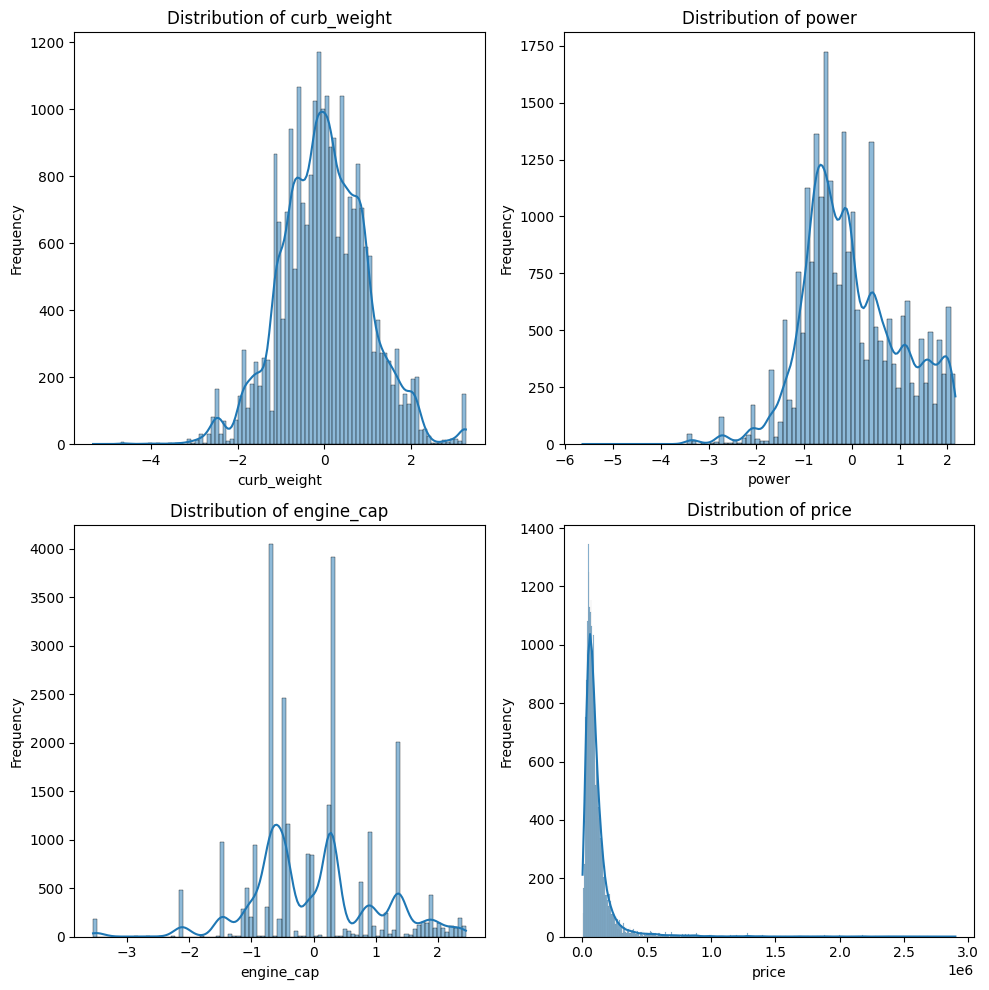

In [11]:
## Change the column list (must be a list of 4)

# cols = ['curb_weight','power','engine_cap','no_of_owners',
# 'depreciation','coe','road_tax','dereg_value',
# 'mileage','omv','arf','coe_age_left',
# 'age_range','car_age','cylinder_cnt','emission_data','price']
cols = ['curb_weight','power','engine_cap','price']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(cols):
    sns.histplot(data=all_df[cols], x=column, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

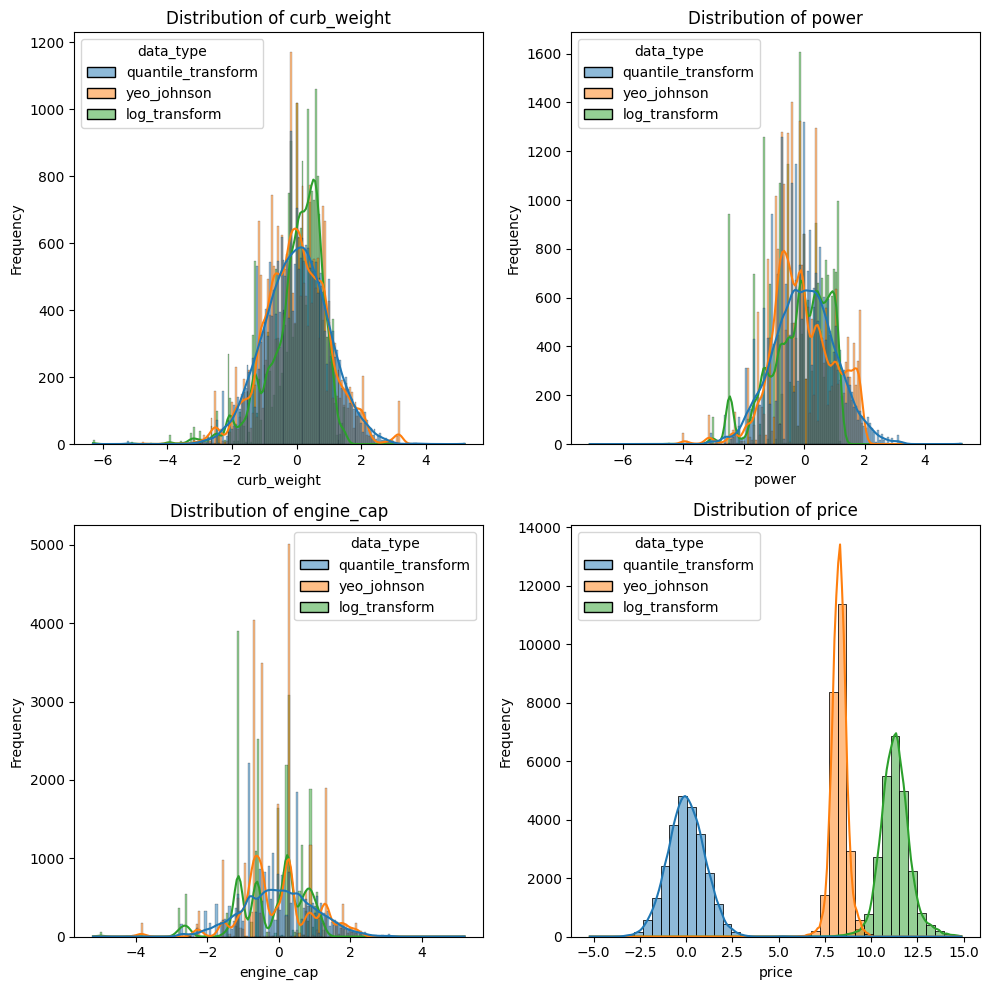

In [12]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
transform_all_data = transform_all_data[transform_all_data.data_type != "original"]

for i, column in enumerate(cols):
    sns.histplot(data=transform_all_data, x=column, hue="data_type", kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Feature Selection

### Filter Methods

In [13]:
# Variation Thresholding
cols = ['curb_weight','power','engine_cap','no_of_owners',
'depreciation','coe','road_tax','dereg_value',
'mileage','omv','arf','coe_age_left',
'age_range','car_age','cylinder_cnt','emission_data']
# Removing variation with less than 25% variation
variance_selector = VarianceThreshold(threshold = 0.01)
variance_selector.fit(X_data[cols])
# True means that it has high variation and false means low variation (lower than 25%)
cols_with_var_unscaled = X_data[cols].columns[variance_selector.get_support()].tolist()

In [15]:
# Variation Thresholding
# Removing variation with less than 25% variation
variance_selector = VarianceThreshold(threshold = 0.1)
variance_selector.fit(scaled_data[cols])
# True means that it has high variation and false means low variation (lower than 25%)
cols_with_var = scaled_data[cols].columns[variance_selector.get_support()].tolist()

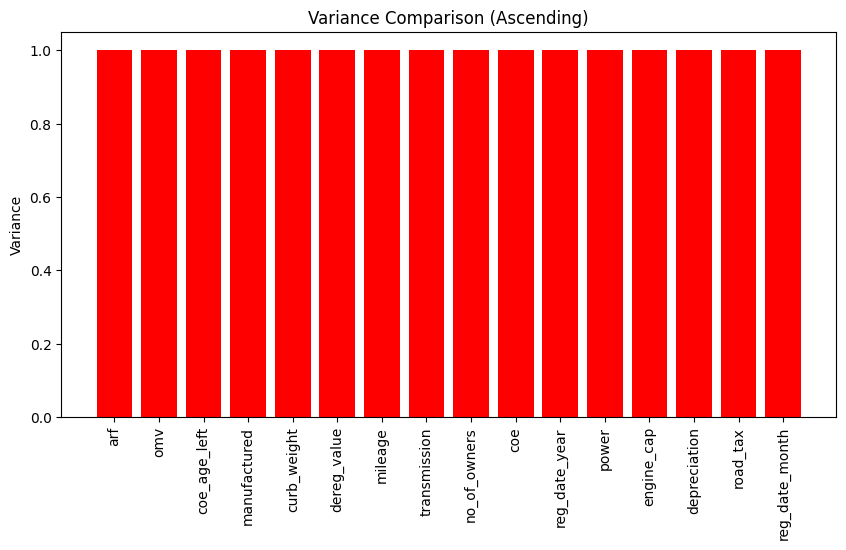

In [16]:
# Sort variances in ascending order
sorted_indices = variance_selector.variances_.argsort()  # No reverse for ascending order
sorted_variances = variance_selector.variances_[sorted_indices]
sorted_features = X_data.columns[sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, height=sorted_variances, color='red')
plt.xticks(rotation='vertical')
plt.ylabel('Variance')
plt.title('Variance Comparison (Ascending)')
plt.show()


In [21]:
# Anova
cols = ['curb_weight','power','engine_cap','no_of_owners',
'depreciation','coe','road_tax','dereg_value',
'mileage','omv','arf',
'age_range','car_age','cylinder_cnt','emission_data','price']
f_df = all_df[cols].dropna()
f_value = f_regression(f_df.drop(columns=["price"]), f_df["price"])

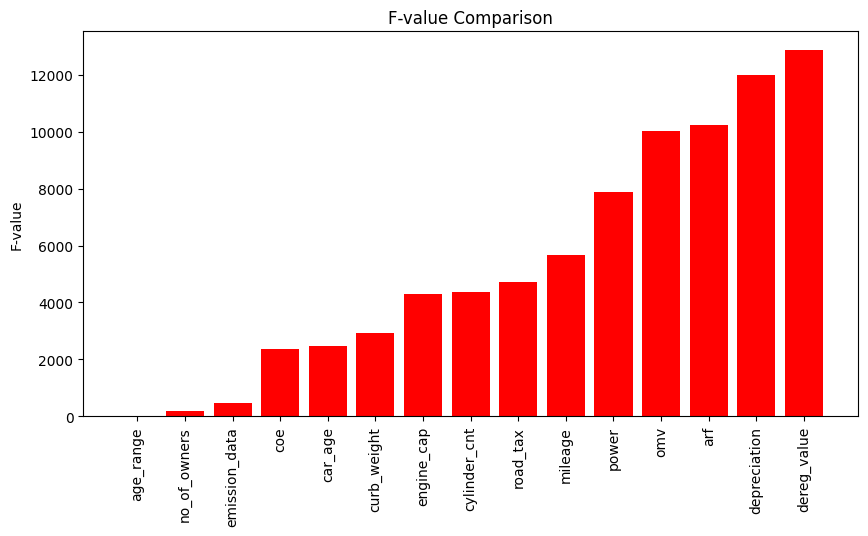

In [22]:
"""
ANOVA F-value estimates the degree of linearity between the input feature (i.e., independent 
features) and the output feature (i.e., dependent feature).A high F-value indicates a high 
degree of linearity and a low F-value indicates a low degree of linearity.
"""

# # Create a bar chart
# plt.figure(figsize=(10,5))
# plt.bar(X_data.columns, height=f_value[0], color='red')
# plt.xticks(rotation='vertical')
# plt.ylabel('F-value')
# plt.title('F-value Comparison')
# plt.show()

# Sort F-values in ascending order
sorted_indices = f_value[0].argsort()  # No reverse for ascending order
sorted_f_values = f_value[0][sorted_indices]
sorted_features = all_df[cols].columns[sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, height=sorted_f_values, color='red')
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()


In [ ]:
## Mutual Information
"""
Mutual information (MI) measures the dependence of one variable to another by quantifying the
 amount of information obtained about one feature, through the other feature. MI is symmetric 
 and non-negative and is equal to zero if and only if two random variables are independent,
and higher values mean higher dependency.
"""

# create mutual_info_classif object
MI_score = mutual_info_regression(X_data, y_data, random_state=0)

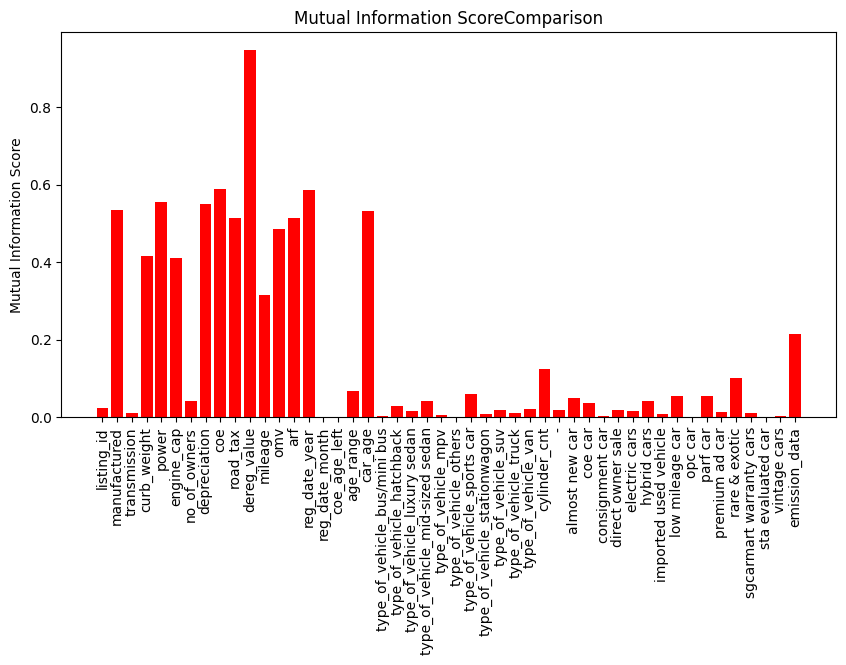

In [51]:
# Create a bar chart
variable = "Mutual Information Score"
plt.figure(figsize=(10,5))
plt.bar(X_data.columns, height=MI_score, color='red')
plt.xticks(rotation='vertical')
plt.ylabel(f'{variable}')
plt.title(f'{variable}Comparison')
plt.show()

### Kbest selector as a wrapper

f_regression is suitable for linear regression problems, while mutual_info_regression is more suitable for non-linear regression problems

In [59]:
selector = SelectKBest(score_func=mutual_info_regression, k=5)
selector.fit(X_data, y_data)
print(selector)
X_data.columns[selector.get_support()]

SelectKBest(k=5, score_func=<function mutual_info_regression at 0x7feee3d25550>)


Index(['power', 'depreciation', 'coe', 'dereg_value', 'reg_date_year'], dtype='object')

In [24]:
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_data, y_data)
print(selector)
X_data.columns[selector.get_support()]

SelectKBest(k=5, score_func=<function f_regression at 0x7ffdf33f7940>)


Index(['depreciation', 'dereg_value', 'omv', 'arf', 'rare & exotic'], dtype='object')

### Wrapper Methods

**Sequential Forward Selection (SFS)**
Pros: Small feature sets: SFS can be computationally feasible if you don’t have too many features to test.
Situations with potential multicollinearity: Since it builds up the feature set incrementally, it can sometimes avoid including highly correlated features

Cons: Can miss interactions between features that only show up when certain combinations are selected.

**Sequential Backward Selection (SBS)**
Pros: Large feature sets: SBS is helpful if you have many features and want to reduce the dimensionality without losing significant predictive power. 
Cases where you expect most features to be irrelevant: It starts with all features, so it’s good if you suspect only a few features are relevant.

Cons: Like SFS, it can miss feature interactions that could improve the model.

**Recursive Feature Elimination (RFE)**

Pros: High-dimensional datasets: RFE is suitable for cases where feature interactions are crucial, as it iteratively re-evaluates feature importance.
When you need a robust, optimized subset: RFE tends to find the optimal set better than purely sequential approaches, particularly when interactions exist between features.

Feature importance ranking: It’s useful when you need not just a subset of features but also an ordered ranking of their importance.

cons : Computationally more expensive than SFS and SBS because it repeatedly fits the model after each feature elimination.

In practice, RFE often performs best in terms of producing a highly optimized subset, especially with models like Support Vector Machines (SVMs) or tree-based models where recursive elimination can leverage inherent feature importance.

In [22]:
## Recursive Feature Elimination (RFE)
model = ensemble.RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_data[cols_with_var], y_data)
ranking = rfe.ranking_

In [31]:
X_data[cols_with_var].columns[rfe.support_]
ranking

Index(['power', 'depreciation', 'dereg_value', 'arf', 'reg_date_year'], dtype='object')

### Correlation Plot

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'price'),
  Text(0, 1.5, 'dereg_value'),
  Text(0, 2.5, 'arf'),
  Text(0, 3.5, 'omv'),
  Text(0, 4.5, 'depreciation'),
  Text(0, 5.5, 'power'),
  Text(0, 6.5, 'cylinder_cnt'),
  Text(0, 7.5, 'engine_cap'),
  Text(0, 8.5, 'road_tax'),
  Text(0, 9.5, 'curb_weight'),
  Text(0, 10.5, 'coe'),
  Text(0, 11.5, 'reg_date_year'),
  Text(0, 12.5, 'manufactured'),
  Text(0, 13.5, 'emission_data'),
  Text(0, 14.5, 'coe_age_left'),
  Text(0, 15.5, 'reg_date_month'),
  Text(0, 16.5, 'age_range'),
  Text(0, 17.5, 'no_of_owners'),
  Text(0, 18.5, 'car_age'),
  Text(0, 19.5, 'mileage')])

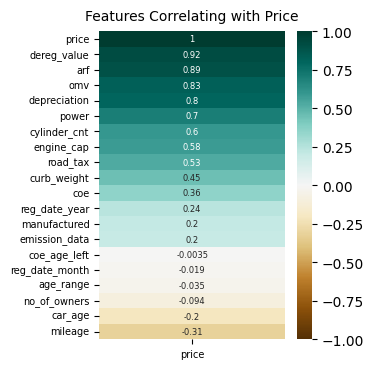

In [24]:
# Just Price Relations
cols = ['manufactured','curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','reg_date_year','reg_date_month','coe_age_left','age_range','car_age','cylinder_cnt','emission_data','price']
plt.figure(figsize=(3, 4))
heatmap = sns.heatmap(
    all_df[(all_df.type_of_vehicle != "truck") & (all_df.type_of_vehicle != "bus/mini bus")][cols].corr(method="pearson")[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={'size': 6})
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':10}, pad=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'manufactured'),
  Text(0, 1.5, 'curb_weight'),
  Text(0, 2.5, 'power'),
  Text(0, 3.5, 'engine_cap'),
  Text(0, 4.5, 'no_of_owners'),
  Text(0, 5.5, 'depreciation'),
  Text(0, 6.5, 'coe'),
  Text(0, 7.5, 'road_tax'),
  Text(0, 8.5, 'dereg_value'),
  Text(0, 9.5, 'mileage'),
  Text(0, 10.5, 'omv'),
  Text(0, 11.5, 'arf'),
  Text(0, 12.5, 'reg_date_year'),
  Text(0, 13.5, 'reg_date_month'),
  Text(0, 14.5, 'coe_age_left'),
  Text(0, 15.5, 'age_range'),
  Text(0, 16.5, 'car_age'),
  Text(0, 17.5, 'cylinder_cnt'),
  Text(0, 18.5, 'emission_data'),
  Text(0, 19.5, 'price')])

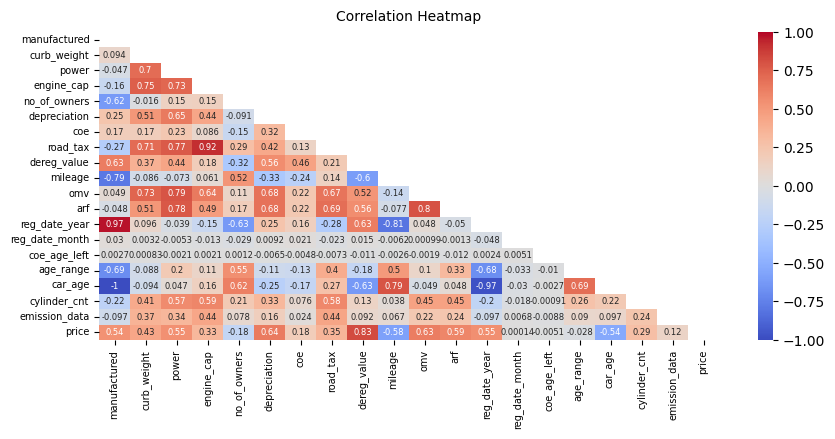

In [26]:
# Increase the size of the heatmap.
plt.figure(figsize=(10, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
# pearson , spearman, kendall
"""
method='pearson': Measures linear relationships, sensitive to outliers.
method='spearman': Measures rank correlation, more robust to outliers.
method='kendall': Another rank-based correlation, but is generally more conservative than Spearman.
"""
corr_df = all_df[cols].corr(method="spearman")
mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True,cmap='coolwarm', annot_kws={'size': 6} )

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=8);
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

In [36]:
# Step 1: Calculate the correlation matrix
corr_matrix = all_df[cols_with_var_unscaled].corr(method="spearman")
percent = 0.30
# Step 2: Flatten the correlation matrix and exclude the diagonal (self-correlation)
# We only need the upper triangle of the matrix to avoid duplicate pairs
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Unstack the upper triangle to get pairs and their correlation values
correlation_pairs = upper_triangle.stack()

# Step 4: Sort the correlation values in descending order
sorted_correlation_pairs = correlation_pairs.sort_values(ascending=False)

# Step 5: Select the top 30% of the highest correlations
top_n_percent = sorted_correlation_pairs.head(int(len(sorted_correlation_pairs) * 0.30))

# Show the result
print(f" Top {percent} for {top_n_percent}")

 Top 0.3 for engine_cap    road_tax         0.919961
omv           arf              0.798317
power         omv              0.791870
mileage       car_age          0.790569
power         arf              0.778023
              road_tax         0.766710
curb_weight   engine_cap       0.752638
              omv              0.733604
power         engine_cap       0.725789
curb_weight   road_tax         0.705045
              power            0.696836
age_range     car_age          0.692741
road_tax      arf              0.690538
depreciation  arf              0.679621
              omv              0.675983
road_tax      omv              0.666639
power         depreciation     0.647115
engine_cap    omv              0.640891
no_of_owners  car_age          0.622642
engine_cap    cylinder_cnt     0.592281
road_tax      cylinder_cnt     0.578883
power         cylinder_cnt     0.565865
depreciation  dereg_value      0.557106
dereg_value   arf              0.556684
no_of_owners  age_range    

## [feature Engineering] Distribution Plots

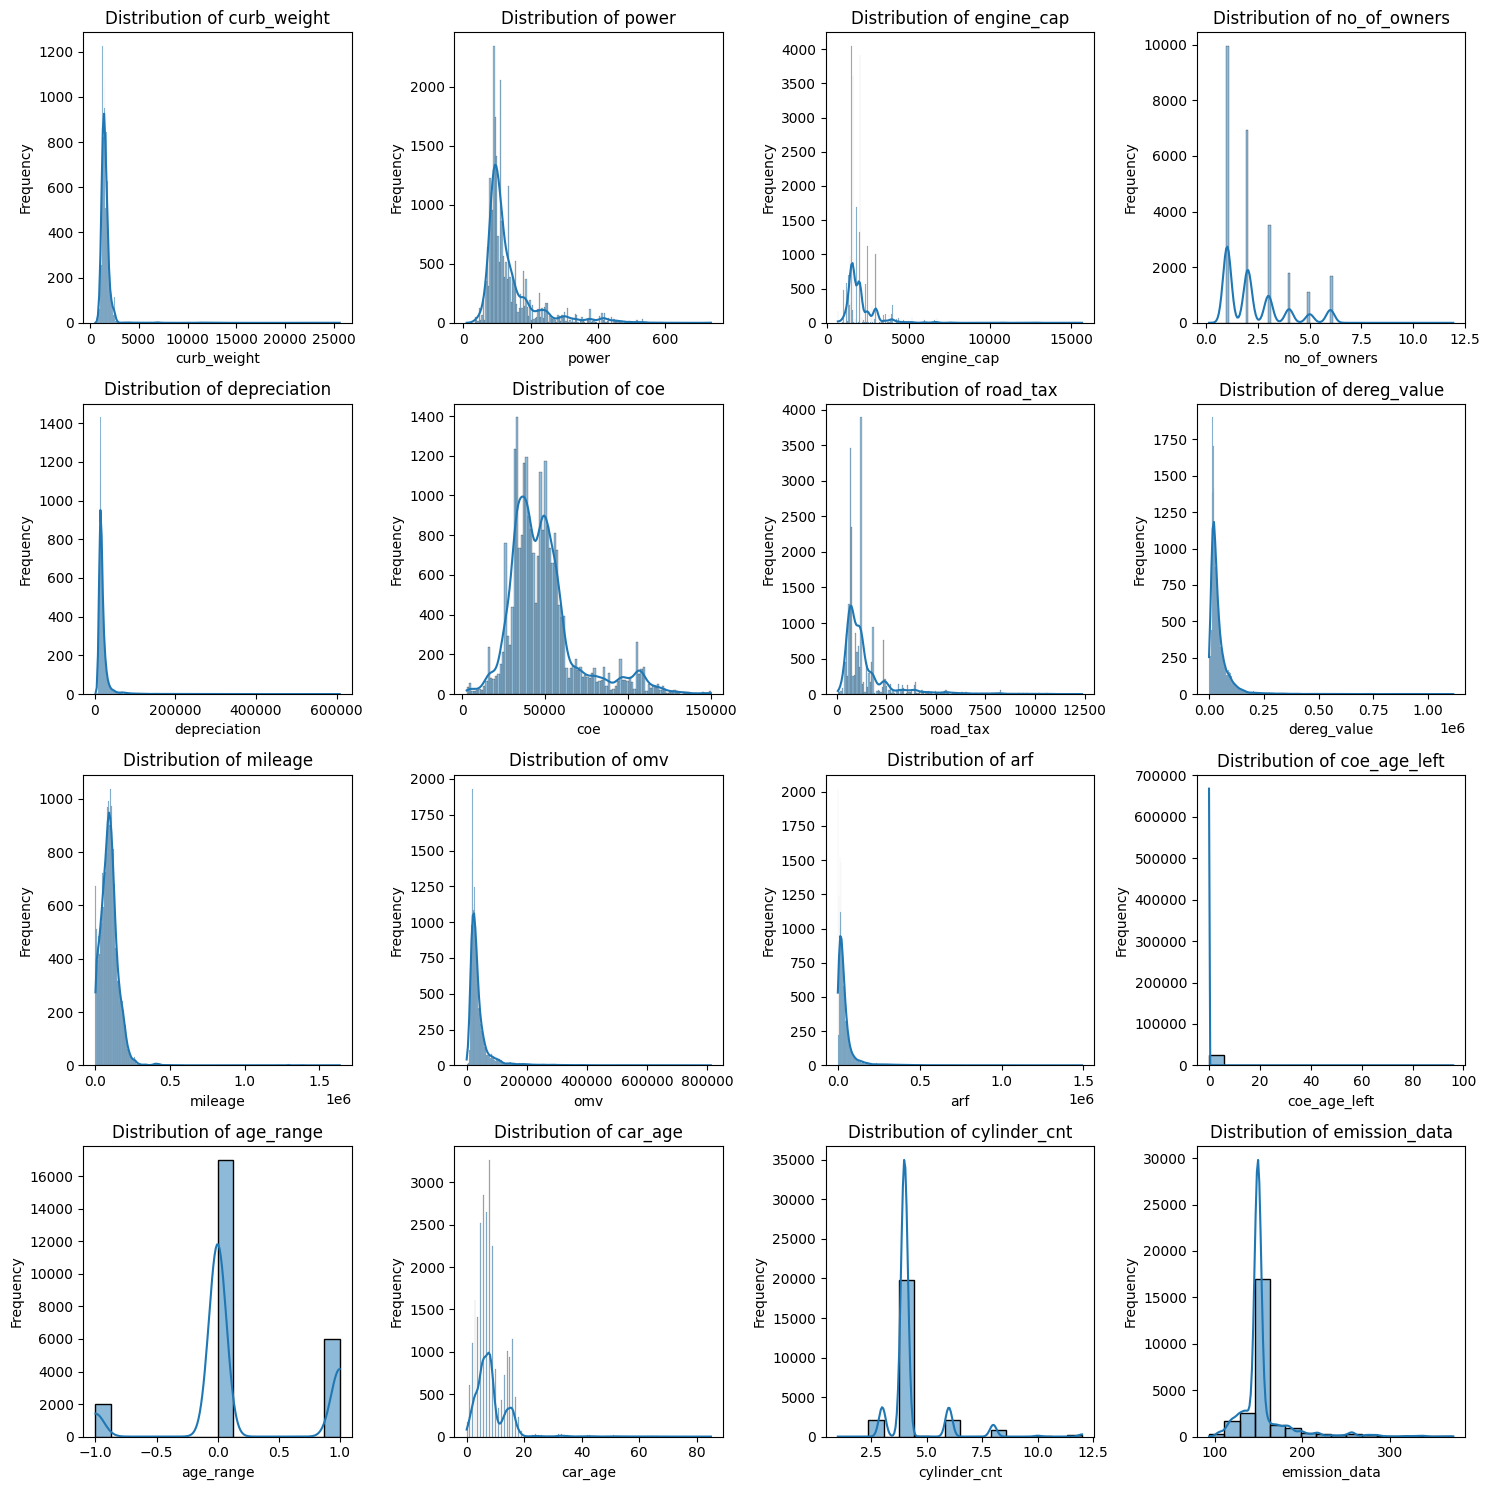

In [29]:
cols = ['curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','coe_age_left','age_range','car_age','cylinder_cnt','emission_data']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(cols):
    sns.histplot(data=X_data, x=column, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(val_numeric_columns), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Model Selection

Ref: https://github.com/esentri/datascience_blog_resources/blob/master/model_selection.ipynb

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb

from IPython.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble, svm, tree, linear_model
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold,f_regression,mutual_info_regression, SelectKBest, RFE, SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error



reg_dt =  tree.DecisionTreeRegressor(random_state=0)
reg_rf = ensemble.RandomForestRegressor(random_state=0)
reg_ridge = linear_model.Ridge()
reg_knn = KNeighborsRegressor()
reg_gb = ensemble.GradientBoostingRegressor(random_state=0)
reg_svr = svm.SVR()

reg_xgb = xgb.XGBRegressor(
    subsample=0.6, n_estimators=200, max_features=0.6, max_depth=4, learning_rate=0.05, random_state=0
)
reg_lgb = lgb.LGBMRegressor(
    n_estimators=300, min_data_in_leaf=20, max_depth=5, learning_rate=0.1, lambda_l2=1.2,
    lambda_l1=1.5, feature_fraction=0.6, bagging_fraction=1.0,random_state=42
)

pipe_ridge  = Pipeline([('std', StandardScaler()),
                     ('reg_ridge', reg_ridge)])

pipe_svr = Pipeline([('std', StandardScaler()),
                     ('reg_svr', reg_svr)])

pipe_knn = Pipeline([('std', StandardScaler()),
                     ('reg_knn', reg_knn)])

pipe_xgb = Pipeline([('std', StandardScaler()),
                     ('reg_xgb', reg_xgb)])

pipe_lgb = Pipeline([('std', StandardScaler()),
                     ('reg_xgb', reg_lgb)])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1195: RuntimeWarning:

libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.



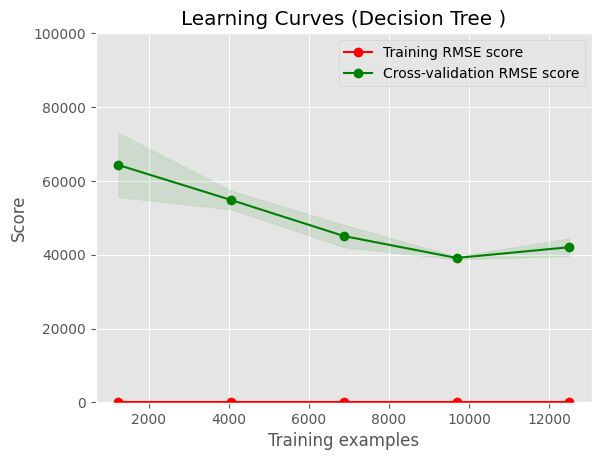

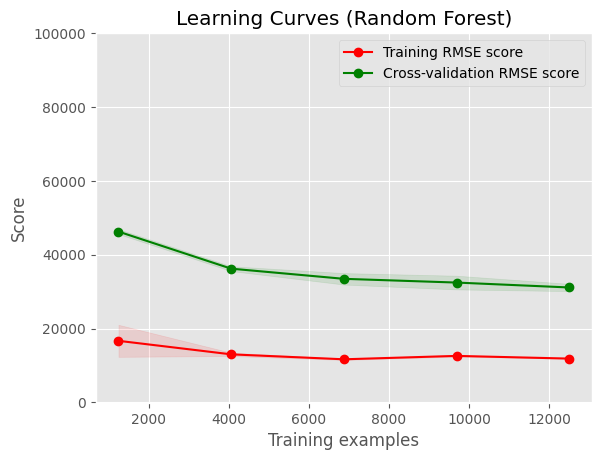

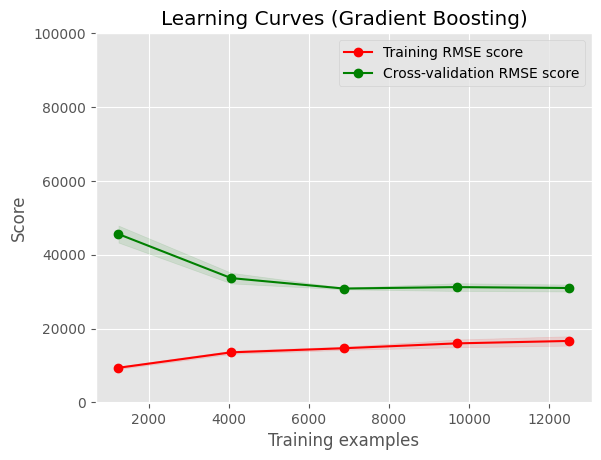

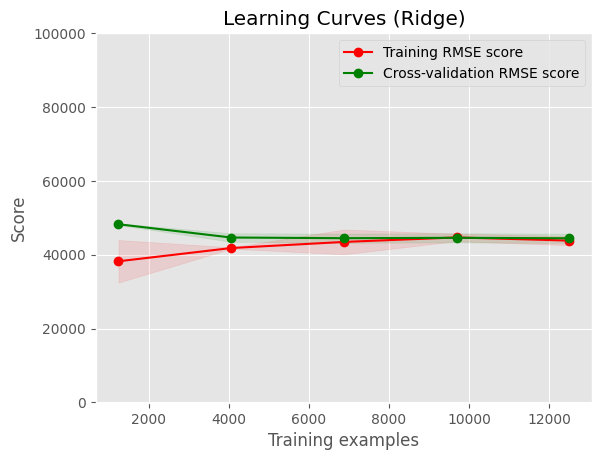

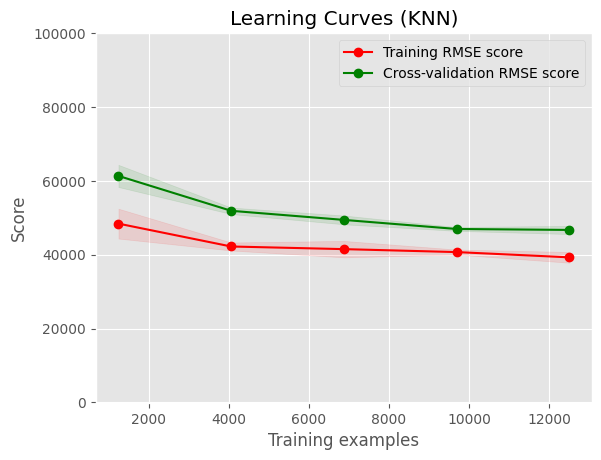

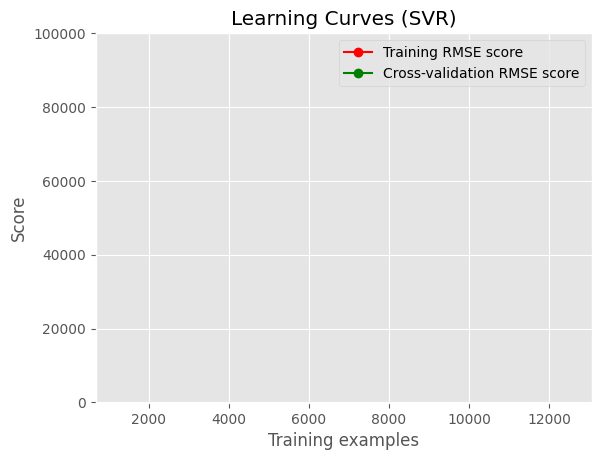

In [ ]:
plt.style.use('ggplot')
%matplotlib inline

def plot_learning_curve(estimator, reg, X, y, ylim=None, cv=None, train_sizes=None):
    plt.figure()
    plt.title(f'Learning Curves ({reg})')
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring="neg_root_mean_squared_error")
    train_scores_mean = abs(np.mean(train_scores, axis=1))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = abs(np.mean(test_scores, axis=1))
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training RMSE score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation RMSE score")

    plt.legend(loc="best")
    plt.grid(True)
    return

train_sizes = np.linspace(.1, 1.0, 5)
ylim = (-100, 100000)
cv = 2
plot_learning_curve(reg_dt, "Decision Tree ", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(reg_rf, "Random Forest", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(reg_gb, "Gradient Boosting", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_ridge, "Ridge", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_knn, "KNN", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_svr, "SVR", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)

plt.show()